# Tidal Envelope Extraction

This notebook demonstrates how to extract tidal envelopes from a noisy, gappy synthetic tide signal composed of semidiurnal and diurnal tidal components.

---




## What is a tidal envelope?

A tidal envelope defines the bounds within which the tide oscillates:

- **Outer envelope** identifies the *highest high waters* (HHW) and *lowest low waters* (LLW).  
- **Inner envelope** identifies the *high low waters* (HLW) and *low high waters* (LHW), which are subtler inflection points in a mixed tide.

These concepts are useful for distinguishing **primary** and **secondary** tides, especially in mixed semidiurnal/diurnal regimes.

---
s
## Example Tide

Let's create a synthetic example tide with enough compications to see the features of the envelope extraction. Tides are often decomposed into "constituents" (equivalent for our purposes here to individual frequencies, although there is a bit more to it) and species (diurnal, semidiurnal) which are clusters of constituents that share similar periodicity.  

- **M2** is the principal lunar semidiurnal tide (~12.42 hr period).
- **D1** here represents the sum of **O1** and **K1**, the principal diurnal components (~24 hr). Their interaction produces the asymmetry seen in mixed tides.

An interesting quirk of the Bay-Delta tides is that O1 and K1 are pretty big and the two come in and out of phase every two weeks and this produces a lot of what people call the spring-neap cycle. Let's be assured our sample, which dumbs the tide down to these three constituents, has that character:


In [ ]:
from envelope import tidal_envelope, generate_simplified_mixed_tide
import numpy as np
import matplotlib.pyplot as plt

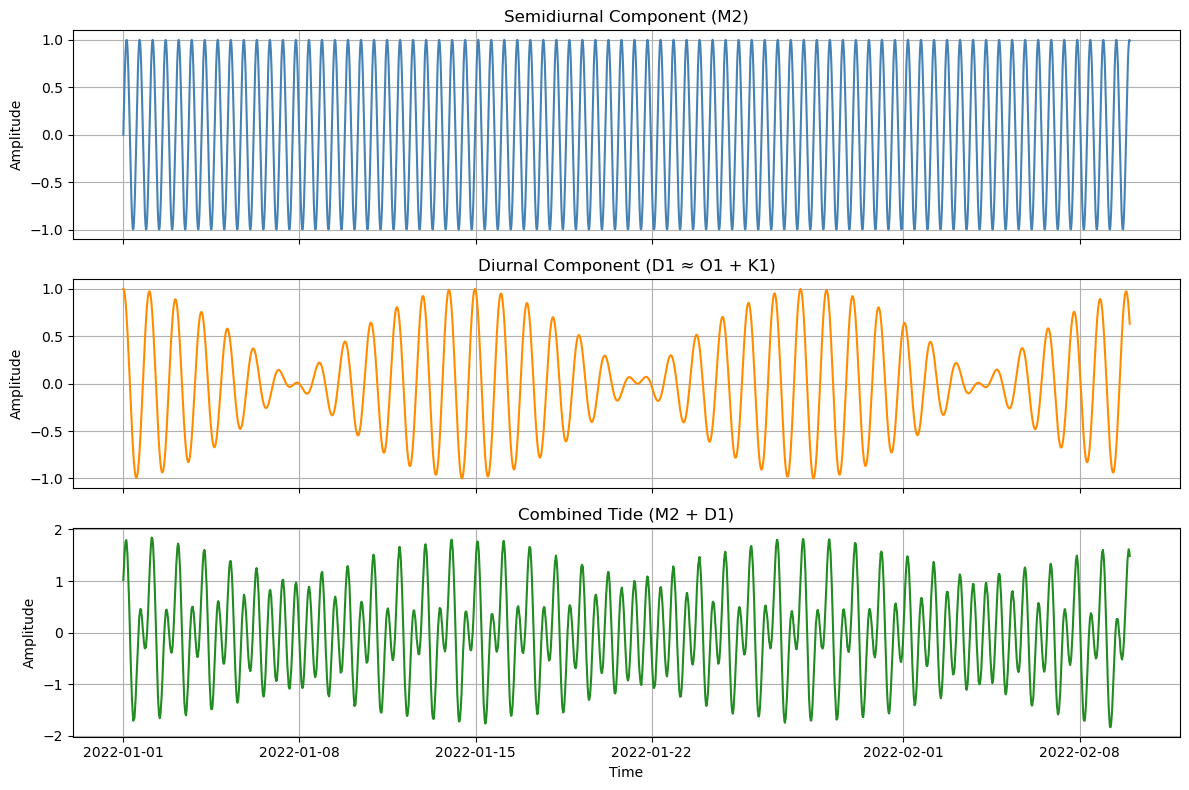

In [ ]:
components = generate_simplified_mixed_tide(ndays=40, return_components=True,noise_amplitude=0.05)

# Plot with three subplots: M2, D1, and Tide
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(components["M2"].index, components["M2"].values, color="steelblue")
axes[0].set_title("Semidiurnal Component (M2)")
axes[0].set_ylabel("Amplitude")

D1 = components["O1"] + components["K1"]
axes[1].plot(D1.index, D1.values, color="darkorange")
axes[1].set_title("Diurnal Component (D1 ≈ O1 + K1)")
axes[1].set_ylabel("Amplitude")

axes[2].plot(components["tide"].index, components["tide"].values, color="forestgreen")
axes[2].set_title("Combined Tide (M2 + D1)")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Time")

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()

## Outer vs Inner Envelope Example (40-day signal with gaps)

The above plot shows the components needed to create a basic San Francisco-like tide (note that the sun and the moon are not essential for this. That is a feature of Pacific Coastal tide composition). Now lets  extract the tidal envelope for the full signal, which is the green "Combined Tide" shown above. The signal has significant white and pink noise attached. You can play with that by changing "noise_amplitude" to 0.2, in which case the envelope gets distorted. 

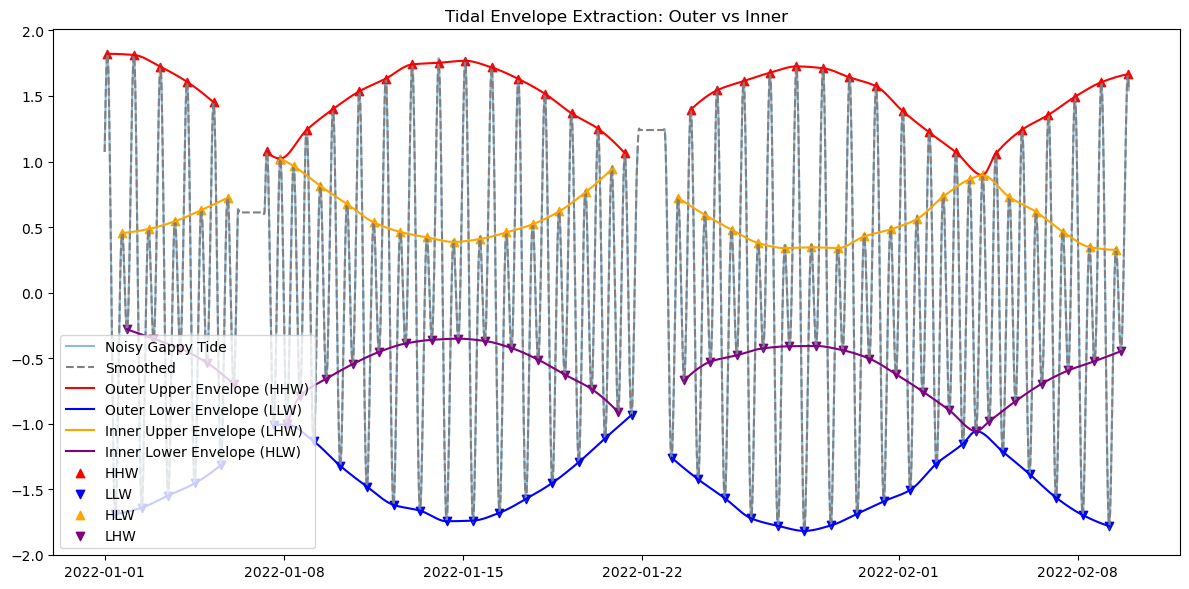

In [ ]:
components = generate_simplified_mixed_tide(ndays=40, return_components=True,noise_amplitude=0.05)
tide = components["tide"].copy()

# Insert synthetic gaps
tide.iloc[500:600] = np.nan
tide.iloc[2000:2100] = np.nan

# Extract outer and inner envelopes
env_high, env_low, anchor_highs, anchor_lows, smooth = tidal_envelope(tide, envelope_type="outer")
env_high_in, env_low_in, anchor_highs_in, anchor_lows_in, _ = tidal_envelope(tide, envelope_type="inner")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tide, label="Noisy Gappy Tide", alpha=0.5)
plt.plot(smooth, label="Smoothed", color="gray", linestyle="--")
plt.plot(env_high, label="Outer Upper Envelope (HHW)", color="red")
plt.plot(env_low, label="Outer Lower Envelope (LLW)", color="blue")
plt.plot(env_high_in, label="Inner Upper Envelope (LHW)", color="orange")
plt.plot(env_low_in, label="Inner Lower Envelope (HLW)", color="purple")
plt.scatter(anchor_highs["time"], anchor_highs["value"], color="red", marker="^", label="HHW")
plt.scatter(anchor_lows["time"], anchor_lows["value"], color="blue", marker="v", label="LLW")
plt.scatter(anchor_highs_in["time"], anchor_highs_in["value"], color="orange", marker="^", label="HLW")
plt.scatter(anchor_lows_in["time"], anchor_lows_in["value"], color="purple", marker="v", label="LHW")
plt.legend()
plt.title("Tidal Envelope Extraction: Outer vs Inner")
plt.tight_layout()
plt.show()

### Understanding Mixed Tides: The Interaction of M2 and D1

In many estuaries, including San Francisco Bay, the tide is **mixed** — a combination of both **semidiurnal** and **diurnal** components.

- **M2** is the dominant **semidiurnal** tide (period ≈ 12.42 hours), producing two high tides and two low tides per day.
- **D1** represents the combined effect of **diurnal** constituents — primarily **O1** (≈25.82 h) and **K1** (≈23.93 h). These create once-per-day fluctuations that can **amplify or diminish** individual semidiurnal highs and lows. Complicating things further, O1 and K1 themselves come in and out of alignment with one another enhancing one another or canceling so that (as shown above) the diurnal signal varies wildly in amplitude. 

#### How M2 and D1 Interact

The tide observed at a location particularly in the Bay-Delta is the **sum** of M2 and D1 signals. Depending on their **relative phase** and **amplitudes**, this interaction can shape the tidal pattern in different ways:

- When **D1 is in phase** (ie timing aligns) with one M2 high tide and **out of phase** with the other, it **enhances one high tide** and **diminishes the other** — this results in alternating **high-high (HH)** and **low-high (LH)** tides. The same applies to low tides, producing **low-low (LL)** and **high-low (HL)** alternations.
- This beat pattern is what gives rise to the classic **mixed tide** with **diurnal inequality**: successive highs and lows that differ significantly in height. 

There are some coincidences about how this varies through the year. The biggest tides of the year occur when the alignment of the biggest D1 tides tallies with that of the semi-diurnal tides and the phase is locked. This leaves a very weak neap, and it produces a really big tidal inequality between the primary and secondary tides. This isn't the case everywhere, but it is an important Bay-Delta feature. See the excellent Kvale (2006) The origin of neap-spring tidal cycles for more info. 

#### The Role of Phase and Amplitude

- The **amplitude** of D1 determines **how unequal** the highs and lows become. A larger D1 creates a stronger beat and more noticeable difference between HH and LH.
- The **phase** of D1 (i.e., how it aligns with M2) determines **when** the inequality occurs:
  - Some phases amplify **high tides** more than lows.
  - Other phases exaggerate **low tides**.
  - In between, both highs and lows may be affected.

At San Francisco, the **diurnal components are strong enough** and well-phased such that the tide often exhibits this **alternating pattern**, making envelope-based descriptions — like **high-high (HH)** and **low-low (LL)** envelopes — useful tools for analyzing and predicting tidal behavior. The relative timing of the diurnal and semi-diurnal components changes over the year (and we have simplified the description of each). 


We can explore this by shifting  D1 relative to M2. The actual phases are arbitrary (it depends on the time datum), but the effect of shifting D1 versus M2 is pertinent.


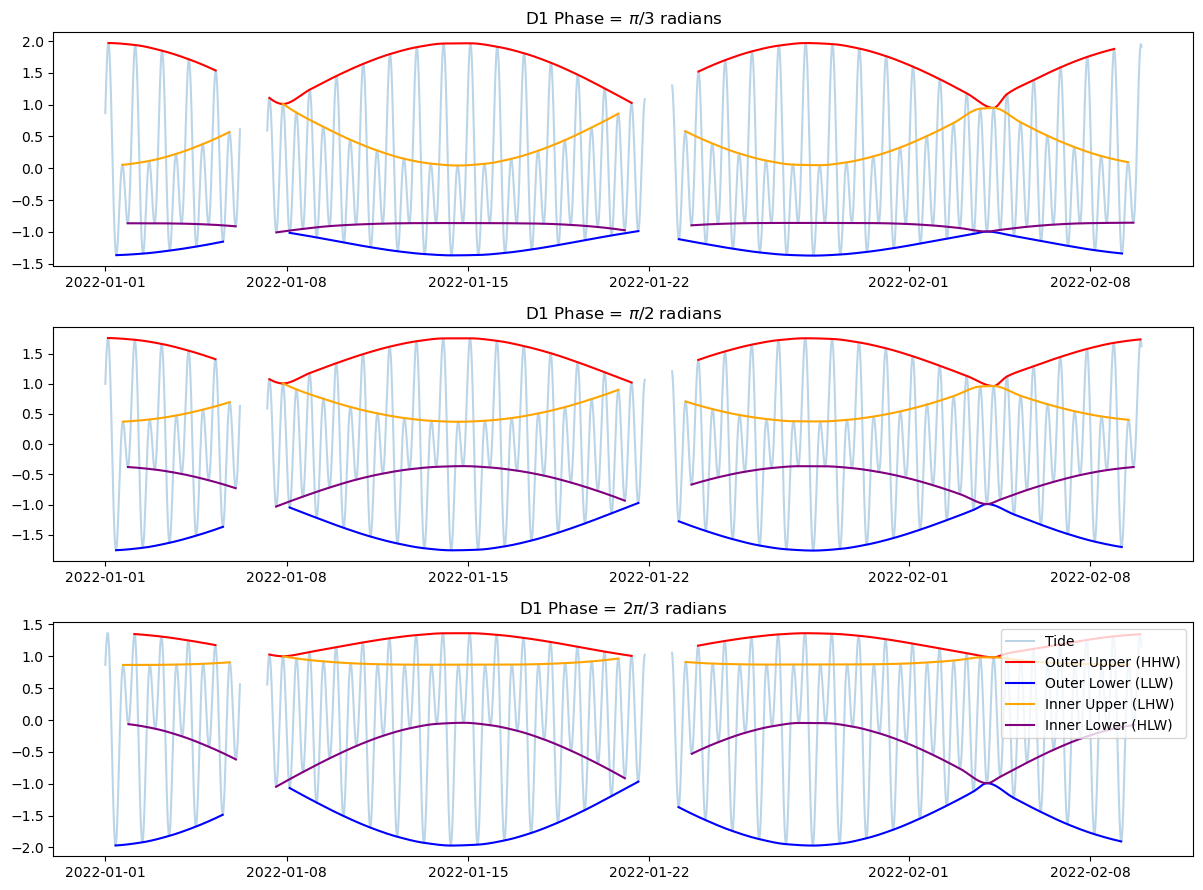

In [ ]:
phases = [np.pi/3, np.pi/2, 2*np.pi/3]
plt.figure(figsize=(12, 9))

phase_labels = ["$\pi/3$", "$\pi/2$", "$2\pi/3$"]
for i, phase in enumerate(phases):
    comps = generate_simplified_mixed_tide(ndays=40, phase_D1=phase, return_components=True,noise_amplitude=0.001)
    tide = comps["tide"].copy()
    tide.iloc[500:600] = np.nan
    tide.iloc[2000:2100] = np.nan

    env_hi, env_lo, *_ = tidal_envelope(tide, envelope_type="outer")
    env_hi_in, env_lo_in, *_ = tidal_envelope(tide, envelope_type="inner")

    ax = plt.subplot(len(phases), 1, i+1)
    ax.plot(tide, alpha=0.3, label="Tide")
    ax.plot(env_hi, color="red", label="Outer Upper (HHW)")
    ax.plot(env_lo, color="blue", label="Outer Lower (LLW)")
    ax.plot(env_hi_in, color="orange", label="Inner Upper (LHW)")
    ax.plot(env_lo_in, color="purple", label="Inner Lower (HLW)")
    ax.set_title(f"D1 Phase = {phase_labels[i]} radians")
    if i == len(phases)-1:
        ax.legend(loc="upper right")

plt.tight_layout()
plt.show()